In [520]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score 




In [521]:
# Check if there any GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPU available') # avaiable count GPU
    print (f'Using "{torch.cuda.get_device_name(0)}" as the GPU', ) # name using GPU  
else:
    print ('No gpu avaiable')
    device = torch.device('cpu')

There are 1 GPU available
Using "NVIDIA GeForce RTX 3060 Ti" as the GPU


### EDA

In [522]:
df = pd.read_csv("Customer-Churn-Records.csv")
df.tail()

# no null/nan

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0,0,3,DIAMOND,911


In [523]:
df = df.drop(['RowNumber', 'CustomerId', 'Geography', 'Surname'], axis=1)

In [524]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Gender              10000 non-null  object 
 2   Age                 10000 non-null  int64  
 3   Tenure              10000 non-null  int64  
 4   Balance             10000 non-null  float64
 5   NumOfProducts       10000 non-null  int64  
 6   HasCrCard           10000 non-null  int64  
 7   IsActiveMember      10000 non-null  int64  
 8   EstimatedSalary     10000 non-null  float64
 9   Exited              10000 non-null  int64  
 10  Complain            10000 non-null  int64  
 11  Satisfaction Score  10000 non-null  int64  
 12  Card Type           10000 non-null  object 
 13  Point Earned        10000 non-null  int64  
dtypes: float64(2), int64(10), object(2)
memory usage: 1.1+ MB


In [525]:
df_cardType = pd.unique(df['Card Type'])
satisfy = df['Satisfaction Score'].unique()
tenor = df['Tenure'].max()
credits = df

max_bal = df['Balance'].max()
min_bal = df['Balance'].min()

ls = [df_cardType, max_bal, min_bal, satisfy, tenor]

for i in ls:
    print(i, "|", end=" ")


['DIAMOND' 'GOLD' 'SILVER' 'PLATINUM'] | 250898.09 | 0.0 | [2 3 5 4 1] | 10 | 

In [526]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


                    CreditScore       Age  ...  Satisfaction Score  Point Earned
CreditScore            1.000000 -0.003965  ...           -0.012599      0.000077
Age                   -0.003965  1.000000  ...           -0.000876      0.002222
Tenure                 0.000842 -0.009997  ...            0.008663     -0.010196
Balance                0.006268  0.028308  ...           -0.002588      0.014608
NumOfProducts          0.012238 -0.030680  ...           -0.011394     -0.015330
HasCrCard             -0.005458 -0.011721  ...           -0.000212     -0.011041
IsActiveMember         0.025651  0.085472  ...            0.010236     -0.004983
EstimatedSalary       -0.001384 -0.007201  ...           -0.013747     -0.001515
Exited                -0.026771  0.285296  ...           -0.005849     -0.004628
Complain              -0.027048  0.283530  ...           -0.004799     -0.002893
Satisfaction Score    -0.012599 -0.000876  ...            1.000000     -0.014400
Point Earned           0.000

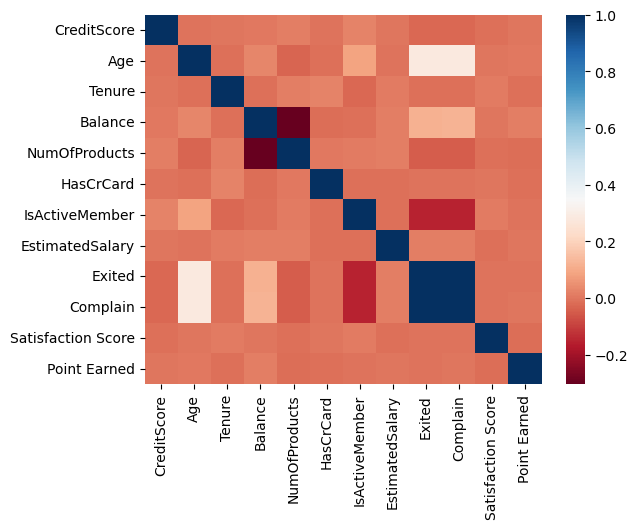

In [527]:
corr_data = df.corr(numeric_only=True)
print(corr_data)

corr = sns.heatmap(corr_data, cmap="RdBu", annot=False)

plt.show(corr)

In [528]:
df.corr(numeric_only=True)["Exited"].sort_values(ascending=False)

Exited                1.000000
Complain              0.995693
Age                   0.285296
Balance               0.118577
EstimatedSalary       0.012490
Point Earned         -0.004628
Satisfaction Score   -0.005849
HasCrCard            -0.006976
Tenure               -0.013656
CreditScore          -0.026771
NumOfProducts        -0.047611
IsActiveMember       -0.156356
Name: Exited, dtype: float64

### Feature 

In [529]:
X = df.drop(['Exited', 'Complain'], axis=1)
y = df['Exited']
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [530]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Gender              10000 non-null  object 
 2   Age                 10000 non-null  int64  
 3   Tenure              10000 non-null  int64  
 4   Balance             10000 non-null  float64
 5   NumOfProducts       10000 non-null  int64  
 6   HasCrCard           10000 non-null  int64  
 7   IsActiveMember      10000 non-null  int64  
 8   EstimatedSalary     10000 non-null  float64
 9   Satisfaction Score  10000 non-null  int64  
 10  Card Type           10000 non-null  object 
 11  Point Earned        10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [531]:
categorical_cols = ['Gender', 'Card Type']
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 
                  'Satisfaction Score', 'Point Earned']

In [532]:
X = df[numerical_cols + categorical_cols]
y = df["Exited"]

In [533]:
numerical_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='mean')),
  ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('encoding', OneHotEncoder(handle_unknown='ignore'))
])

preprocessing_pipeline = ColumnTransformer([
  ('num', numerical_pipeline, numerical_cols),
  ('cat', categorical_pipeline, categorical_cols)
])

pipeline = Pipeline([
  ('preprocessor', preprocessing_pipeline),
  ('model', XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    eval_metric="logloss",
    random_state=42
  ))
])

In [534]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size= 0.2, 
    stratify=y, 
    random_state=42
)

In [535]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'EstimatedSalary',
                                                   'Satisfaction Score',
                                                   'Point Earned']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encodi...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [536]:
Xt = pipeline.named_steps['preprocessor'].fit_transform(X_train)
print(type(Xt), Xt.shape)

<class 'numpy.ndarray'> (8000, 15)


In [ ]:
prediction = pipeline.predict(X_test)
# y_prob = pipeline.predict_proba(X_test)[:, 1]
# y_pred = (prediction >= 0.3).astype(int)

In [538]:
y_prob_test = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob_test)
print("ROC-AUC:", auc)

ROC-AUC: 0.8444381835648832


In [539]:
# mse = mean_squared_error(y_test, prediction)
# rmse = np.sqrt(mse)

# r2 = r2_score(y_test, prediction)
# mae = mean_absolute_error(y_test, prediction)
cm = confusion_matrix(y_test, prediction)

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1592
           1       0.67      0.42      0.51       408

    accuracy                           0.84      2000
   macro avg       0.76      0.68      0.71      2000
weighted avg       0.82      0.84      0.82      2000



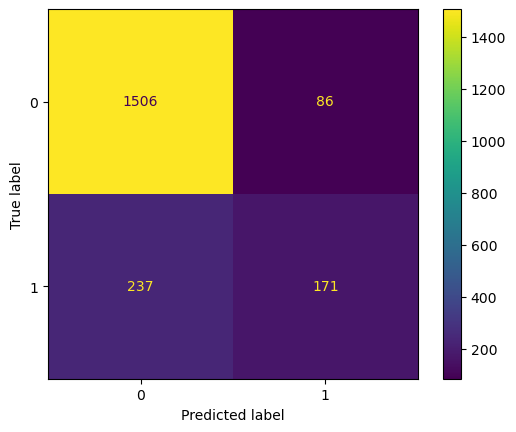

In [540]:
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [541]:
tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

Accuracy : 0.8385
Precision: 0.6653696498054474
Recall   : 0.41911764705882354
F1-score : 0.5142857142857143


In [542]:
df["churn_prob"] = pipeline.predict_proba(X)[:, 1]

In [543]:
# Rules 
q_low  = df["churn_prob"].quantile(0.4)
q_mid  = df["churn_prob"].quantile(0.6)
q_high = df["churn_prob"].quantile(0.95)

def assign_priority(row):
    if row["churn_prob"] >= q_high and row["Balance"] <= 50000:
        return "high_prio"
    elif row["churn_prob"] >= q_mid:
        return "moderate"
    elif row["churn_prob"] >= q_low:
        return "low_prio"
    else:
        return "neutral"

df["priority"] = df.apply(assign_priority, axis=1)

In [544]:
df.groupby("priority")["Exited"].mean()

priority
high_prio    0.922078
low_prio     0.098000
moderate     0.413417
neutral      0.027500
Name: Exited, dtype: float64

In [545]:
df.groupby("priority").agg(
    churn_rate=("Exited", "mean"),
    avg_prob=("churn_prob", "mean"),
    count=("Exited", "size")
)

,churn_rate,avg_prob,count
priority,,,
high_prio,0.922078,0.814873,154
low_prio,0.098000,0.118194,2000
moderate,0.413417,0.393264,3846
neutral,0.027500,0.043824,4000


In [546]:
df["priority"].value_counts(normalize=True)

neutral      0.4000
moderate     0.3846
low_prio     0.2000
high_prio    0.0154
Name: priority, dtype: float64

In [547]:
X2 = df[numerical_cols + categorical_cols]
y2 = df["priority"]

le = LabelEncoder()
y2_enc = le.fit_transform(y2)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2_enc,
    test_size=0.2,
    stratify=y2_enc,
    random_state=42
)

pipeline.fit(X2_train, y2_train)
pred = pipeline.predict(X2_test)

In [548]:
cm = confusion_matrix(y2_test, pred)
print(cm)

print(classification_report(
    y2_test,
    pred,
    target_names=le.classes_
))

[[ 23   0   8   0]
 [  0 313  43  44]
 [  1  43 722   3]
 [  0  59   0 741]]
              precision    recall  f1-score   support

   high_prio       0.96      0.74      0.84        31
    low_prio       0.75      0.78      0.77       400
    moderate       0.93      0.94      0.94       769
     neutral       0.94      0.93      0.93       800

    accuracy                           0.90      2000
   macro avg       0.90      0.85      0.87      2000
weighted avg       0.90      0.90      0.90      2000



In [549]:
le.classes_

array(['high_prio', 'low_prio', 'moderate', 'neutral'], dtype=object)

In [550]:
pd.DataFrame(
    pipeline.named_steps["model"].feature_importances_,
    index=pipeline.named_steps["preprocessor"].get_feature_names_out()
).sort_values(0, ascending=False).head(10)

,0
num__NumOfProducts,0.321833
num__Age,0.178007
cat__Gender_Female,0.155734
num__Balance,0.104693
cat__Card Type_SILVER,0.049287
num__Satisfaction Score,0.042071
num__EstimatedSalary,0.024309
num__Point Earned,0.021474
cat__Card Type_DIAMOND,0.021224
cat__Card Type_GOLD,0.021002
